In [1]:
# Import the required packages and libs.
from single_intersection import TrafficEnv
import numpy as np
import os 
import matplotlib.pyplot as plt
import time
from sumo_rl import SumoEnvironment
import torch
# Print the sumo environment path for further verification 
print("SUMO HOME:", os.environ.get("SUMO_HOME"))
# SUMO HOME: /opt/miniconda3/lib/python3.13/site-packages/sumo

SUMO HOME: /opt/miniconda3/lib/python3.13/site-packages/sumo


In [2]:
def env_force_quite():
    """ArithmeticError: Integer division or modulo by zero: force quite the sumo environment."""
    import traci
    try:
        if traci.isLoaded():
            traci.close(False)
    except Exception:
        pass

## Environment Testing

In [6]:
env_force_quite()

sumo_cmd = [
    # "--start", # Uncomment this line while using the GUI for visualization 
    "--no-warnings", "true", # Uncomment this line to 
    "-n", "single-intersection.net.xml",
    "-r", "single-intersection-vertical.rou.xml",
    "--step-length", "1.0"
]

TLS_ID = "t"    

# import traci
# traci.close(False)

# Initialize SUMO environment
env = TrafficEnv(
    sumo_cmd=sumo_cmd,
    tls_id=TLS_ID,
    gui=False   # Render the environment to set it to True
)
if env:
    print("SUMO Environment successfully initialized!")
# Test if the environment is working properly with 100 steps
state = env.reset()
done = False
truncated = False
counter = 100
while not done and not truncated and counter > 0:
    counter -= 1
    action = env.action_space.sample()  # Sample random action
    next_state, reward, done, truncated, info = env.step(action)
    # env.render() # Uncomment this line to visualize the environment
    # Print every 20 steps with the .3 float value of the action
    if counter % 20 == 0:
        print(f"Step: {100 - counter}, Action: {action}, Reward: {reward}, Info: {info}")

env.close()


Step #40.00 (0ms ?*RT. ?UPS, TraCI: 10188ms, vehicles TOT 34 ACT 30 BUF 0)                
 Retrying in 1 seconds


/Users/yongchen/Documents/MIE/ECE1508F3/smartTrafficControll_ece1508_group_project/single_intersection.py:48: UserWarning: Call to deprecated function getCompleteRedYellowGreenDefinition, use getAllProgramLogics instead.
  num_phases = len(self.sumo.trafficlight.getCompleteRedYellowGreenDefinition(self.ts_id)[0].phases)


SUMO Environment successfully initialized!
Step #0.00 (0ms ?*RT. ?UPS, TraCI: 5ms, vehicles TOT 0 ACT 0 BUF 0)                      
 Retrying in 1 seconds
Step: 20, Action: 6, Reward: -13.1, Info: {'avg_speed': np.float64(4.212955851190537), 'throughput': 0, 'waiting_time': np.float64(5.76), 'queue_length': 15, 'pressure': 44}
Step: 40, Action: 1, Reward: -20.7, Info: {'avg_speed': np.float64(2.8065420800688616), 'throughput': 0, 'waiting_time': np.float64(10.372093023255815), 'queue_length': 31, 'pressure': 76}
Step: 60, Action: 4, Reward: -24.0, Info: {'avg_speed': np.float64(0.9436458959870246), 'throughput': 0, 'waiting_time': np.float64(12.557692307692308), 'queue_length': 36, 'pressure': 88}
Step: 80, Action: 6, Reward: -36.599999999999994, Info: {'avg_speed': np.float64(0.4934087844924381), 'throughput': 0, 'waiting_time': np.float64(6.791044776119403), 'queue_length': 54, 'pressure': 116}
Step: 100, Action: 5, Reward: -30.5, Info: {'avg_speed': np.float64(0.8061441963525499), 

## Training Section

In [27]:
from ppo import ActorCritic
from run_experiments import evaluate_agent
import train    
import pandas as pd

env_force_quite()

train_model_configs_tuning = {
    "LR": [3e-4, 1e-4, 5e-5], 
    "MINI_BATCH_SIZE": [32, 64, 256],
    "clip_range": [0.1, 0.2],
    "gamma": [0.95, 0.99],
    "TOTAL_TIMESTEPS": 4096 * 4
}

# Train the agent with hyperparameter tuning
# You can reset the tuning dictionary to tune the parameters you want
# Here we will read the tuned results from a file instead of training again
tuned_results_file = pd.read_csv("results/tune_para_summary.csv", sep=None, engine="python")
tuned_results_file


,LR,Mini-batch,Clip,Gamma,Avg Return
0,0.00030,32,0.1,0.95,-38.2
1,0.00030,32,0.1,0.99,-39.5
2,0.00030,32,0.2,0.95,-38.8
3,0.00030,32,0.2,0.99,-30.7
4,0.00030,64,0.2,0.99,-32.9
5,0.00030,64,0.1,0.95,-25.3
6,0.00030,64,0.1,0.99,-30.3
7,0.00030,256,0.2,0.95,-37.6
8,0.00030,256,0.2,0.99,-38.1
9,0.00010,32,0.1,0.99,-35.8


In [28]:
best_config= tuned_results_file.iloc[tuned_results_file['Avg Return'].idxmax()]
print("Best Config from Tuning:\n", best_config)


Best Config from Tuning:
 LR             0.0003
Mini-batch    64.0000
Clip           0.1000
Gamma          0.9500
Avg Return   -25.3000
Name: 5, dtype: float64


### Here we build the different environment first

In [ ]:
# Import the required packages and libs.
from single_intersection import TrafficEnv
from train import train_ppo
import torch.optim as optim
from ppo import ActorCritic, compute_gae, collect_rollout
from torch import nn
from helper_func import plot_traff_metrics


# SUMO command (headless for speed)
sumo_cmd = [
    # "--start", # Uncomment this line while using the GUI for visualization 
    "--no-warnings", "true", # Uncomment this line to 
    "-n", "single-intersection.net.xml",
    "-r", "single-intersection-vertical.rou.xml",
    "--step-length", "1.0"
]

TLS_ID = "t"    

# Environment with noise 
env_w_noise = TrafficEnv(
    sumo_cmd=sumo_cmd,
    tls_id=TLS_ID,
    gui=False,
    noise=True,
    noise_sigma=1.0
)

# Check if the environment is working 
obs, info = env.reset()
print(f"Environment {env.__class__.__name__} setup complete.")

# Basic Envivronment without noise (default)
env = TrafficEnv(
    sumo_cmd=sumo_cmd,
    tls_id=TLS_ID,
    gui=False   # show SUMO GUI
)

# Check if the environment is working 
obs, info = env.reset()
print(f"Environment {env.__class__.__name__} setup complete. ")



STAGE 1: Finding best reward function and noise combination (RL agent)


Stage 1 - Experiment 1: Noise=False, Reward=default
 Retrying in 1 seconds


/Users/yongchen/Documents/MIE/ECE1508F3/smartTrafficControll_ece1508_group_project/single_intersection.py:48: UserWarning: Call to deprecated function getCompleteRedYellowGreenDefinition, use getAllProgramLogics instead.
  num_phases = len(self.sumo.trafficlight.getCompleteRedYellowGreenDefinition(self.ts_id)[0].phases)


Training RL agent...
Step #0.00 (0ms ?*RT. ?UPS, TraCI: 65ms, vehicles TOT 0 ACT 0 BUF 0)                     
 Retrying in 1 seconds
Step #0.00 (0ms ?*RT. ?UPS, TraCI: 8ms, vehicles TOT 0 ACT 0 BUF 0)                      
 Retrying in 1 seconds
[Training] Step 256/16384 (1.6%) | Reward: -26.166 | Waiting time: 7.180 | Queue length: 33.531 | Throughput: 0.266 |Avg Speed: 1.951 | Pressure: 106.527
Step #512.00 (0ms ?*RT. ?UPS, TraCI: 119ms, vehicles TOT 323 ACT 100 BUF 39)              
 Retrying in 1 seconds
[Training] Step 512/16384 (3.1%) | Reward: -29.913 | Waiting time: 8.763 | Queue length: 40.254 | Throughput: 0.242 |Avg Speed: 1.633 | Pressure: 115.824
Step #512.00 (0ms ?*RT. ?UPS, TraCI: 43ms, vehicles TOT 289 ACT 107 BUF 73)               
 Retrying in 1 seconds
[Training] Step 768/16384 (4.7%) | Reward: -30.723 | Waiting time: 12.201 | Queue length: 42.582 | Throughput: 0.242 |Avg Speed: 1.385 | Pressure: 117.059
Step #512.00 (0ms ?*RT. ?UPS, TraCI: 40ms, vehicles TOT 248 AC

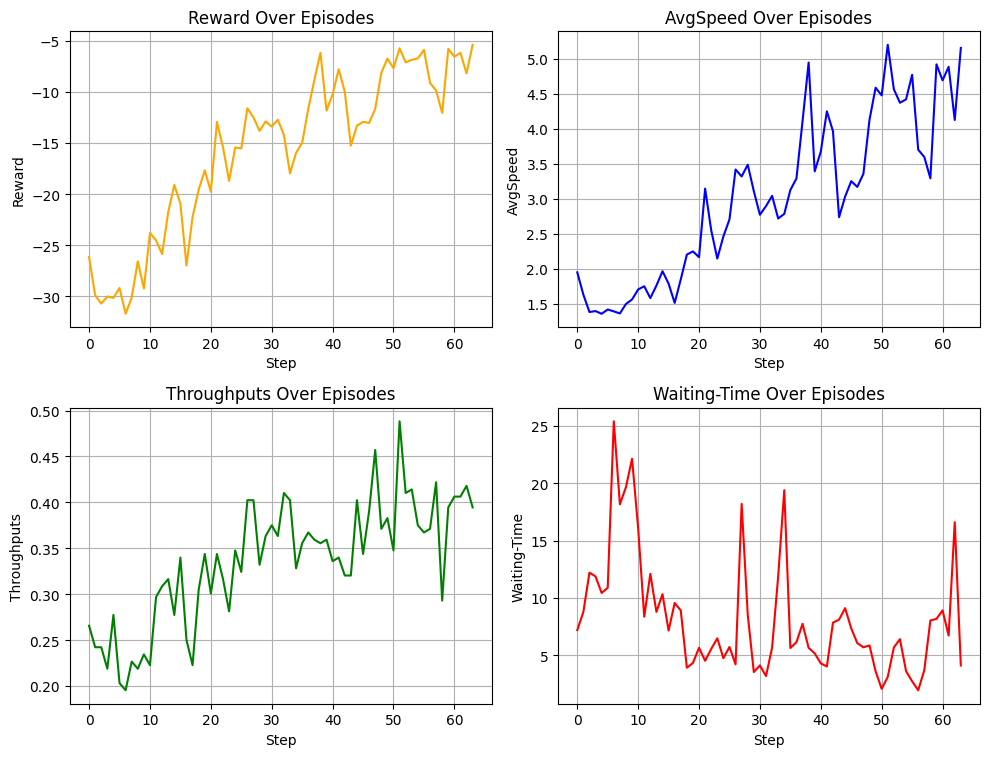

Step #512.00 (0ms ?*RT. ?UPS, TraCI: 285ms, vehicles TOT 362 ACT 41 BUF 0)                
 Retrying in 1 seconds


/Users/yongchen/Documents/MIE/ECE1508F3/smartTrafficControll_ece1508_group_project/single_intersection.py:48: UserWarning: Call to deprecated function getCompleteRedYellowGreenDefinition, use getAllProgramLogics instead.
  num_phases = len(self.sumo.trafficlight.getCompleteRedYellowGreenDefinition(self.ts_id)[0].phases)


Evaluating RL agent...
Step #0.00 (0ms ?*RT. ?UPS, TraCI: 7ms, vehicles TOT 0 ACT 0 BUF 0)                      
 Retrying in 1 seconds
Step #2000.00 (0ms ?*RT. ?UPS, TraCI: 12ms, vehicles TOT 1394 ACT 51 BUF 0)               
Evaluation records saved to: results/stage1_exp1_rl_default_noiseFalse_evaluation_records.csv
Stage 1 - Experiment 1 completed!

Stage 1 - Experiment 2: Noise=False, Reward=queue_focused
 Retrying in 1 seconds


/Users/yongchen/Documents/MIE/ECE1508F3/smartTrafficControll_ece1508_group_project/single_intersection.py:48: UserWarning: Call to deprecated function getCompleteRedYellowGreenDefinition, use getAllProgramLogics instead.
  num_phases = len(self.sumo.trafficlight.getCompleteRedYellowGreenDefinition(self.ts_id)[0].phases)


Training RL agent...
Step #0.00 (0ms ?*RT. ?UPS, TraCI: 7ms, vehicles TOT 0 ACT 0 BUF 0)                      
 Retrying in 1 seconds
Step #0.00 (0ms ?*RT. ?UPS, TraCI: 5ms, vehicles TOT 0 ACT 0 BUF 0)                      
 Retrying in 1 seconds
[Training] Step 256/16384 (1.6%) | Reward: -22.938 | Waiting time: 5.268 | Queue length: 22.938 | Throughput: 0.277 |Avg Speed: 2.146 | Pressure: 76.258
Step #512.00 (0ms ?*RT. ?UPS, TraCI: 38ms, vehicles TOT 309 ACT 71 BUF 53)                
 Retrying in 1 seconds
[Training] Step 512/16384 (3.1%) | Reward: -26.781 | Waiting time: 7.922 | Queue length: 26.781 | Throughput: 0.305 |Avg Speed: 2.059 | Pressure: 75.234
Step #512.00 (1ms ~= 1000.00*RT, ~60000.00UPS, TraCI: 32ms, vehicles TOT 276 ACT 60 BUF 86
 Retrying in 1 seconds
[Training] Step 768/16384 (4.7%) | Reward: -27.949 | Waiting time: 6.619 | Queue length: 27.949 | Throughput: 0.273 |Avg Speed: 1.932 | Pressure: 85.320
Step #512.00 (0ms ?*RT. ?UPS, TraCI: 35ms, vehicles TOT 305 ACT 83

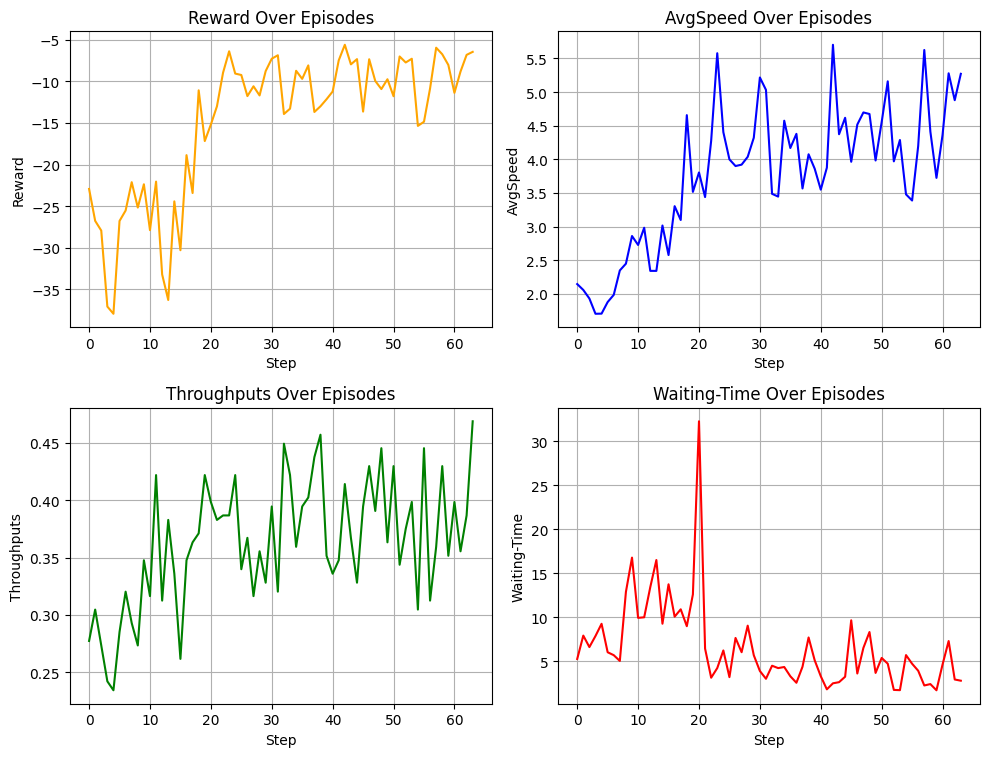

Step #512.00 (1ms ~= 1000.00*RT, ~30000.00UPS, TraCI: 220ms, vehicles TOT 362 ACT 30 BUF 0
 Retrying in 1 seconds


/Users/yongchen/Documents/MIE/ECE1508F3/smartTrafficControll_ece1508_group_project/single_intersection.py:48: UserWarning: Call to deprecated function getCompleteRedYellowGreenDefinition, use getAllProgramLogics instead.
  num_phases = len(self.sumo.trafficlight.getCompleteRedYellowGreenDefinition(self.ts_id)[0].phases)


Evaluating RL agent...
Step #0.00 (0ms ?*RT. ?UPS, TraCI: 6ms, vehicles TOT 0 ACT 0 BUF 0)                      
 Retrying in 1 seconds
Step #2000.00 (0ms ?*RT. ?UPS, TraCI: 12ms, vehicles TOT 1394 ACT 51 BUF 0)               
Evaluation records saved to: results/stage1_exp2_rl_queue_focused_noiseFalse_evaluation_records.csv
Stage 1 - Experiment 2 completed!

Stage 1 - Experiment 3: Noise=False, Reward=pressure_focused
 Retrying in 1 seconds


/Users/yongchen/Documents/MIE/ECE1508F3/smartTrafficControll_ece1508_group_project/single_intersection.py:48: UserWarning: Call to deprecated function getCompleteRedYellowGreenDefinition, use getAllProgramLogics instead.
  num_phases = len(self.sumo.trafficlight.getCompleteRedYellowGreenDefinition(self.ts_id)[0].phases)


Training RL agent...
Step #0.00 (0ms ?*RT. ?UPS, TraCI: 5ms, vehicles TOT 0 ACT 0 BUF 0)                      
 Retrying in 1 seconds
Step #0.00 (0ms ?*RT. ?UPS, TraCI: 5ms, vehicles TOT 0 ACT 0 BUF 0)                      
 Retrying in 1 seconds
[Training] Step 256/16384 (1.6%) | Reward: -131.195 | Waiting time: 15.637 | Queue length: 53.066 | Throughput: 0.223 |Avg Speed: 1.351 | Pressure: 131.195
Step #512.00 (0ms ?*RT. ?UPS, TraCI: 44ms, vehicles TOT 261 ACT 112 BUF 101)              
 Retrying in 1 seconds
[Training] Step 512/16384 (3.1%) | Reward: -119.336 | Waiting time: 13.774 | Queue length: 47.762 | Throughput: 0.203 |Avg Speed: 1.376 | Pressure: 119.336
Step #512.00 (1ms ~= 1000.00*RT, ~108000.00UPS, TraCI: 40ms, vehicles TOT 259 ACT 108 BUF 
 Retrying in 1 seconds
[Training] Step 768/16384 (4.7%) | Reward: -123.141 | Waiting time: 12.736 | Queue length: 46.020 | Throughput: 0.199 |Avg Speed: 1.457 | Pressure: 123.141
Step #512.00 (0ms ?*RT. ?UPS, TraCI: 37ms, vehicles TOT 2

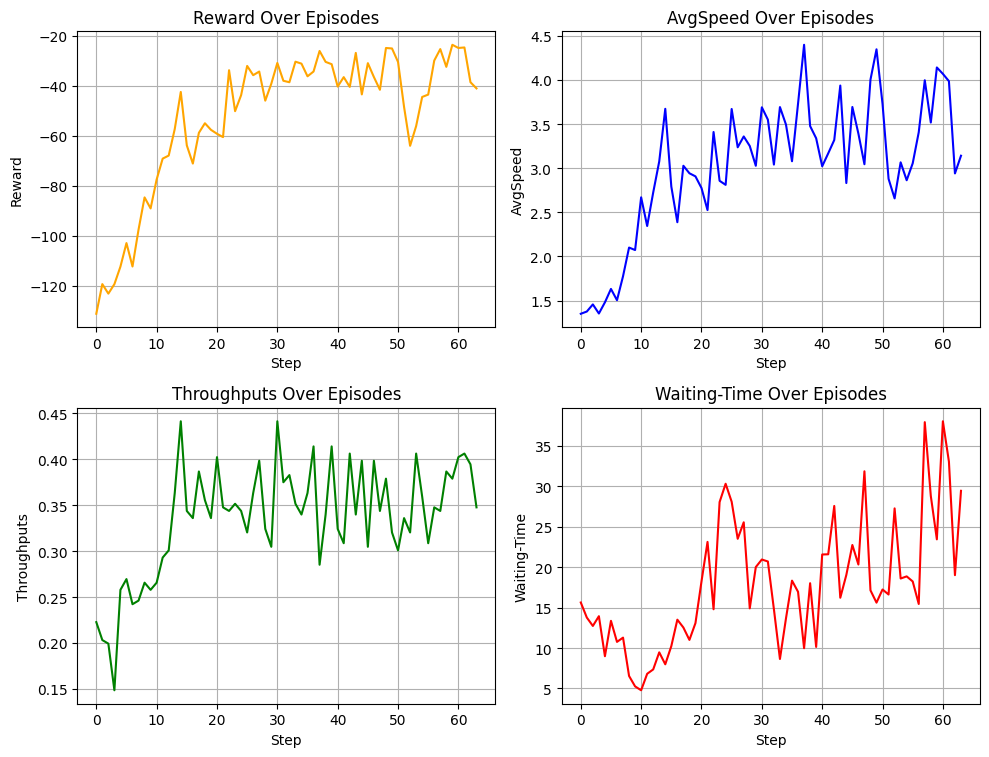

Step #512.00 (1ms ~= 1000.00*RT, ~69000.00UPS, TraCI: 848ms, vehicles TOT 362 ACT 69 BUF 0
 Retrying in 1 seconds


/Users/yongchen/Documents/MIE/ECE1508F3/smartTrafficControll_ece1508_group_project/single_intersection.py:48: UserWarning: Call to deprecated function getCompleteRedYellowGreenDefinition, use getAllProgramLogics instead.
  num_phases = len(self.sumo.trafficlight.getCompleteRedYellowGreenDefinition(self.ts_id)[0].phases)


Evaluating RL agent...
Step #0.00 (0ms ?*RT. ?UPS, TraCI: 6ms, vehicles TOT 0 ACT 0 BUF 0)                      
 Retrying in 1 seconds
Step #2000.00 (0ms ?*RT. ?UPS, TraCI: 24ms, vehicles TOT 1268 ACT 115 BUF 126)            
Evaluation records saved to: results/stage1_exp3_rl_pressure_focused_noiseFalse_evaluation_records.csv
Stage 1 - Experiment 3 completed!

Stage 1 - Experiment 4: Noise=True, Reward=default
 Retrying in 1 seconds


/Users/yongchen/Documents/MIE/ECE1508F3/smartTrafficControll_ece1508_group_project/single_intersection.py:48: UserWarning: Call to deprecated function getCompleteRedYellowGreenDefinition, use getAllProgramLogics instead.
  num_phases = len(self.sumo.trafficlight.getCompleteRedYellowGreenDefinition(self.ts_id)[0].phases)


Training RL agent...
Step #0.00 (0ms ?*RT. ?UPS, TraCI: 6ms, vehicles TOT 0 ACT 0 BUF 0)                      
 Retrying in 1 seconds
Step #0.00 (0ms ?*RT. ?UPS, TraCI: 7ms, vehicles TOT 0 ACT 0 BUF 0)                      
 Retrying in 1 seconds
[Training] Step 256/16384 (1.6%) | Reward: -22.936 | Waiting time: 7.931 | Queue length: 29.707 | Throughput: 0.297 |Avg Speed: 1.942 | Pressure: 91.969
Step #512.00 (0ms ?*RT. ?UPS, TraCI: 39ms, vehicles TOT 286 ACT 79 BUF 76)                
 Retrying in 1 seconds
[Training] Step 512/16384 (3.1%) | Reward: -18.223 | Waiting time: 7.263 | Queue length: 23.918 | Throughput: 0.270 |Avg Speed: 2.076 | Pressure: 71.809
Step #512.00 (0ms ?*RT. ?UPS, TraCI: 31ms, vehicles TOT 280 ACT 53 BUF 82)                
 Retrying in 1 seconds
[Training] Step 768/16384 (4.7%) | Reward: -20.004 | Waiting time: 10.416 | Queue length: 29.246 | Throughput: 0.289 |Avg Speed: 1.863 | Pressure: 73.109
Step #512.00 (0ms ?*RT. ?UPS, TraCI: 31ms, vehicles TOT 261 ACT 5

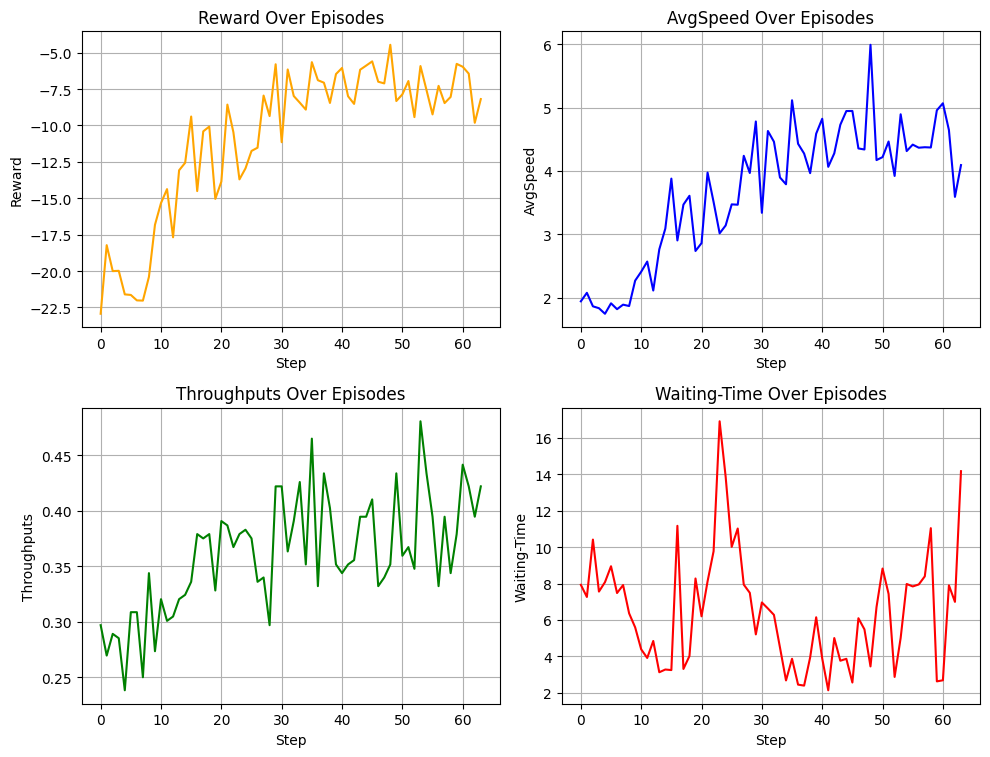

Step #512.00 (0ms ?*RT. ?UPS, TraCI: 243ms, vehicles TOT 362 ACT 53 BUF 0)                
 Retrying in 1 seconds


/Users/yongchen/Documents/MIE/ECE1508F3/smartTrafficControll_ece1508_group_project/single_intersection.py:48: UserWarning: Call to deprecated function getCompleteRedYellowGreenDefinition, use getAllProgramLogics instead.
  num_phases = len(self.sumo.trafficlight.getCompleteRedYellowGreenDefinition(self.ts_id)[0].phases)


Evaluating RL agent...
Step #0.00 (0ms ?*RT. ?UPS, TraCI: 5ms, vehicles TOT 0 ACT 0 BUF 0)                      
 Retrying in 1 seconds
Step #2000.00 (0ms ?*RT. ?UPS, TraCI: 14ms, vehicles TOT 1394 ACT 63 BUF 0)               
Evaluation records saved to: results/stage1_exp4_rl_default_noiseTrue_evaluation_records.csv
Stage 1 - Experiment 4 completed!

Stage 1 - Experiment 5: Noise=True, Reward=queue_focused
 Retrying in 1 seconds


/Users/yongchen/Documents/MIE/ECE1508F3/smartTrafficControll_ece1508_group_project/single_intersection.py:48: UserWarning: Call to deprecated function getCompleteRedYellowGreenDefinition, use getAllProgramLogics instead.
  num_phases = len(self.sumo.trafficlight.getCompleteRedYellowGreenDefinition(self.ts_id)[0].phases)


Training RL agent...
Step #0.00 (0ms ?*RT. ?UPS, TraCI: 8ms, vehicles TOT 0 ACT 0 BUF 0)                      
 Retrying in 1 seconds
Step #0.00 (0ms ?*RT. ?UPS, TraCI: 7ms, vehicles TOT 0 ACT 0 BUF 0)                      
 Retrying in 1 seconds
[Training] Step 256/16384 (1.6%) | Reward: -35.078 | Waiting time: 9.701 | Queue length: 35.078 | Throughput: 0.242 |Avg Speed: 1.624 | Pressure: 104.887
Step #512.00 (0ms ?*RT. ?UPS, TraCI: 38ms, vehicles TOT 263 ACT 84 BUF 99)                
 Retrying in 1 seconds
[Training] Step 512/16384 (3.1%) | Reward: -37.656 | Waiting time: 9.811 | Queue length: 37.656 | Throughput: 0.223 |Avg Speed: 1.588 | Pressure: 108.465
Step #512.00 (0ms ?*RT. ?UPS, TraCI: 36ms, vehicles TOT 266 ACT 88 BUF 96)                
 Retrying in 1 seconds
[Training] Step 768/16384 (4.7%) | Reward: -35.363 | Waiting time: 14.361 | Queue length: 35.363 | Throughput: 0.266 |Avg Speed: 1.707 | Pressure: 93.367
Step #512.00 (0ms ?*RT. ?UPS, TraCI: 36ms, vehicles TOT 263 ACT

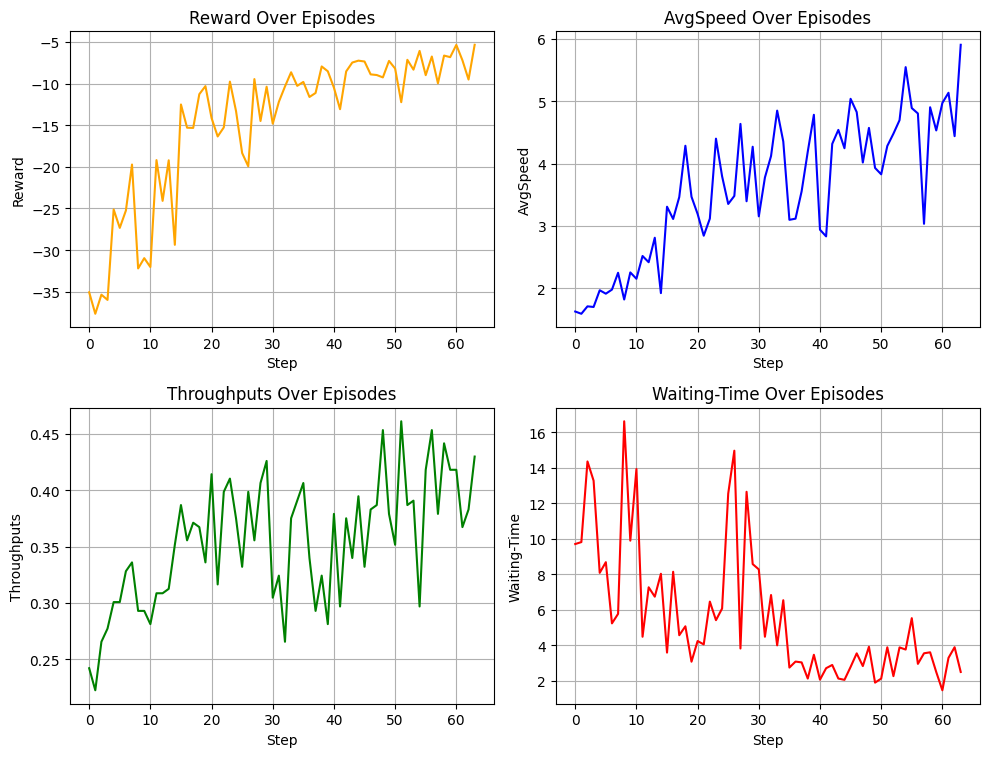

Step #512.00 (0ms ?*RT. ?UPS, TraCI: 233ms, vehicles TOT 362 ACT 31 BUF 0)                
 Retrying in 1 seconds


/Users/yongchen/Documents/MIE/ECE1508F3/smartTrafficControll_ece1508_group_project/single_intersection.py:48: UserWarning: Call to deprecated function getCompleteRedYellowGreenDefinition, use getAllProgramLogics instead.
  num_phases = len(self.sumo.trafficlight.getCompleteRedYellowGreenDefinition(self.ts_id)[0].phases)


Evaluating RL agent...
Step #0.00 (0ms ?*RT. ?UPS, TraCI: 4ms, vehicles TOT 0 ACT 0 BUF 0)                      
 Retrying in 1 seconds
Step #2000.00 (0ms ?*RT. ?UPS, TraCI: 12ms, vehicles TOT 1269 ACT 49 BUF 125)             
Evaluation records saved to: results/stage1_exp5_rl_queue_focused_noiseTrue_evaluation_records.csv
Stage 1 - Experiment 5 completed!

Stage 1 - Experiment 6: Noise=True, Reward=pressure_focused
 Retrying in 1 seconds


/Users/yongchen/Documents/MIE/ECE1508F3/smartTrafficControll_ece1508_group_project/single_intersection.py:48: UserWarning: Call to deprecated function getCompleteRedYellowGreenDefinition, use getAllProgramLogics instead.
  num_phases = len(self.sumo.trafficlight.getCompleteRedYellowGreenDefinition(self.ts_id)[0].phases)


Training RL agent...
Step #0.00 (0ms ?*RT. ?UPS, TraCI: 12ms, vehicles TOT 0 ACT 0 BUF 0)                     
 Retrying in 1 seconds
Step #0.00 (0ms ?*RT. ?UPS, TraCI: 8ms, vehicles TOT 0 ACT 0 BUF 0)                      
 Retrying in 1 seconds
[Training] Step 256/16384 (1.6%) | Reward: -108.980 | Waiting time: 7.055 | Queue length: 36.598 | Throughput: 0.230 |Avg Speed: 1.602 | Pressure: 108.980
Step #512.00 (0ms ?*RT. ?UPS, TraCI: 39ms, vehicles TOT 275 ACT 86 BUF 87)                
 Retrying in 1 seconds
[Training] Step 512/16384 (3.1%) | Reward: -97.223 | Waiting time: 8.389 | Queue length: 32.180 | Throughput: 0.266 |Avg Speed: 1.711 | Pressure: 97.223
Step #512.00 (0ms ?*RT. ?UPS, TraCI: 37ms, vehicles TOT 282 ACT 82 BUF 80)                
 Retrying in 1 seconds
[Training] Step 768/16384 (4.7%) | Reward: -114.703 | Waiting time: 13.646 | Queue length: 44.605 | Throughput: 0.184 |Avg Speed: 1.364 | Pressure: 114.703
Step #512.00 (0ms ?*RT. ?UPS, TraCI: 45ms, vehicles TOT 252 A

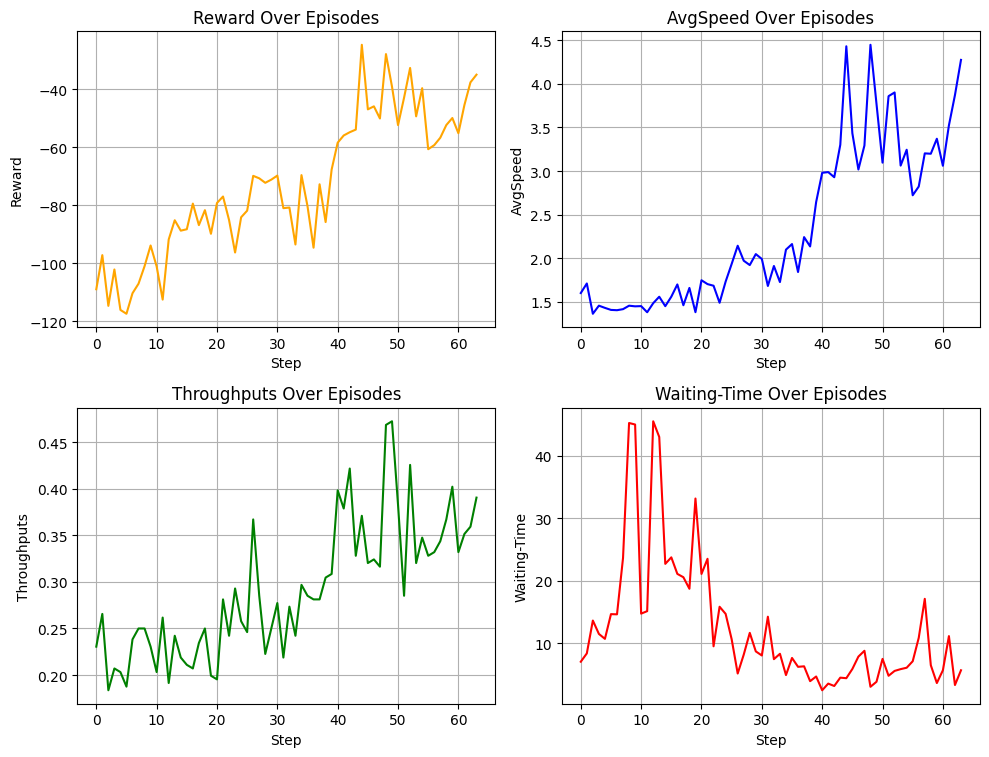

Step #512.00 (1ms ~= 1000.00*RT, ~57000.00UPS, TraCI: 231ms, vehicles TOT 361 ACT 57 BUF 1
 Retrying in 1 seconds


/Users/yongchen/Documents/MIE/ECE1508F3/smartTrafficControll_ece1508_group_project/single_intersection.py:48: UserWarning: Call to deprecated function getCompleteRedYellowGreenDefinition, use getAllProgramLogics instead.
  num_phases = len(self.sumo.trafficlight.getCompleteRedYellowGreenDefinition(self.ts_id)[0].phases)


Evaluating RL agent...
Step #0.00 (0ms ?*RT. ?UPS, TraCI: 5ms, vehicles TOT 0 ACT 0 BUF 0)                      
 Retrying in 1 seconds
Step #2000.00 (0ms ?*RT. ?UPS, TraCI: 15ms, vehicles TOT 1317 ACT 60 BUF 77)              
Evaluation records saved to: results/stage1_exp6_rl_pressure_focused_noiseTrue_evaluation_records.csv
Stage 1 - Experiment 6 completed!

STAGE 1 COMPLETE: Best configuration found!
Best metric (avg_reward): -9.2004
Best noise: False
Best reward function: default
Best reward coefficients: c1=1.0, c2=0.3, c3=0.15, c4=0.05, c5=0.005


STAGE 2: Running Heuristic and RL Agent on best configuration


Stage 2 - Experiment 7: Agent=heuristic
Configuration: Noise=False, Reward=default
 Retrying in 1 seconds


/Users/yongchen/Documents/MIE/ECE1508F3/smartTrafficControll_ece1508_group_project/single_intersection.py:48: UserWarning: Call to deprecated function getCompleteRedYellowGreenDefinition, use getAllProgramLogics instead.
  num_phases = len(self.sumo.trafficlight.getCompleteRedYellowGreenDefinition(self.ts_id)[0].phases)


Using heuristic agent...
Evaluating heuristic agent...
Step #0.00 (0ms ?*RT. ?UPS, TraCI: 6ms, vehicles TOT 0 ACT 0 BUF 0)                      
 Retrying in 1 seconds
Step #2000.00 (1ms ~= 1000.00*RT, ~113000.00UPS, TraCI: 25ms, vehicles TOT 944 ACT 113 BUF
Evaluation records saved to: results/stage2_exp7_heuristic_default_noiseFalse_evaluation_records.csv
Stage 2 - Experiment 7 (heuristic) completed!

Stage 2 - Experiment 8: Agent=rl
Configuration: Noise=False, Reward=default
 Retrying in 1 seconds


/Users/yongchen/Documents/MIE/ECE1508F3/smartTrafficControll_ece1508_group_project/single_intersection.py:48: UserWarning: Call to deprecated function getCompleteRedYellowGreenDefinition, use getAllProgramLogics instead.
  num_phases = len(self.sumo.trafficlight.getCompleteRedYellowGreenDefinition(self.ts_id)[0].phases)


Loading trained RL model from Stage 1...
Evaluating rl agent...
Step #0.00 (0ms ?*RT. ?UPS, TraCI: 39ms, vehicles TOT 0 ACT 0 BUF 0)                     
 Retrying in 1 seconds
Step #2000.00 (1ms ~= 1000.00*RT, ~55000.00UPS, TraCI: 12ms, vehicles TOT 1394 ACT 55 BUF 
Evaluation records saved to: results/stage2_exp8_rl_default_noiseFalse_evaluation_records.csv
Stage 2 - Experiment 8 (rl) completed!

All experiments completed! Summary saved to: results/experiments_summary.csv
Total experiments: 8


Total experiments completed: 8
Check 'results/experiments_summary.csv' for summary of all experiments


In [13]:
# Run experiments across all combinations:
# 1. Noise v.s. Without Noise
# 2. Heuristic v.s. RL Agent
# 3. Different Reward Function 

from run_experiments import run_experiments
import traci




# SUMO command configuration
sumo_cmd = [
    "--no-warnings", "true",
    "-n", "single-intersection.net.xml",
    "-r", "single-intersection-vertical.rou.xml",
    "--step-length", "1.0"
]

TLS_ID = "t"

# Run all experiments
# This will iterate through all combinations:
# - Noise: True/False (2 options)
# - Agent: "heuristic"/"rl" (2 options)  
# - Reward configs: 4 different configurations
# Total: 2 x 2 x 4 = 16 experiments

# queue_reduction， queue_abs， pressure， switch_penalty， throughput\n",
# Reward configurations
reward_configs = [
    ("default", 1.0, 0.3, 0.15, 0.05, 0.005),
    ("queue_focused", 0.0, 1.0, 0.0, 0.0, 0.0),
    ("pressure_focused", 0.0, 0.0, 1.0, 0.0, 0.0)]

# Noise options
noise_options = [True, False]

# PPO training configuration
train_model_configs = {
    "LR": 3e-4, 
    "N_STEPS": 256,
    "N_EPOCHS": 4,
    "MINI_BATCH_SIZE": 64,
    "TOTAL_TIMESTEPS": 4096 * 4
}

# "LR": 3e-4, 
# "N_STEPS": 256,
# "N_EPOCHS": 4,
# "MINI_BATCH_SIZE": 64,
# "TOTAL_TIMESTEPS": 4096 * 4

results = run_experiments(
    sumo_cmd=sumo_cmd,
    tls_id=TLS_ID,
    reward_configs=reward_configs,
    noise_options=noise_options,
    train_model_config=train_model_configs,
    eval_steps=1000,      # Evaluation steps per experiment
    # train_timesteps=4096, # Training timesteps for RL agents (only used for RL experiments)
    seed=42
)

print(f"\nTotal experiments completed: {len(results)}")
print("Check 'results/experiments_summary.csv' for summary of all experiments")



## Performance Evaluation

In [41]:
import pandas as pd
df_exp_summary = pd.read_csv("results/experiments_summary.csv")
df_exp_summary[["experiment_id", "agent"] + [col for col in df_exp_summary.columns if "avg" in col]]



,experiment_id,agent,avg_reward,avg_waiting_time,avg_queue_length,avg_pressure,avg_throughput,avg_speed,last100_avg_reward,last100_avg_waiting_time,last100_avg_throughput,last100_avg_speed
0,1,rl,-9.200360,12.400125,15.326,29.318,0.428,3.517811,-13.20900,24.076533,0.50,2.528184
1,2,rl,-13.743000,3.651281,13.743,51.065,0.398,3.131376,-19.62000,4.732893,0.39,2.419010
2,3,rl,-103.240000,42.199418,52.929,103.240,0.343,1.264182,-131.66000,70.601418,0.37,0.653903
3,4,rl,-10.552470,11.674960,18.202,32.521,0.456,3.193280,-15.48790,9.078124,0.42,2.093367
4,5,rl,-9.885000,1.840888,9.885,55.261,0.368,2.773865,-10.14000,1.738773,0.41,2.294500
5,6,rl,-64.744000,6.608178,22.709,64.744,0.425,2.414403,-74.21000,3.423952,0.49,2.044036
6,7,heuristic,-46.168025,51.505467,79.679,147.896,0.215,0.849302,-53.87865,56.393394,0.17,0.596368
7,8,rl,-9.665755,11.654448,15.637,31.879,0.439,3.369030,-13.13660,24.252244,0.38,2.507858


In [17]:
import pandas as pd
import matplotlib.pyplot as plt
# Plot traffic metrics for all experiments
# df_exp1 = pd.read_csv("results/stage1_exp1_rl_default_noiseFalse_evaluation_records.csv")
# df_exp2 = pd.read_csv("results/stage1_exp2_rl_default_noiseTrue_evaluation_records.csv")
df_exp3 = pd.read_csv("results/stage2_exp7_heuristic_default_noiseFalse_evaluation_records.csv")
df_exp4 = pd.read_csv("results/stage2_exp8_rl_default_noiseFalse_evaluation_records.csv")
# df_exp5 = pd.read_csv("results/stage1")
# df_exp6 = pd.read_csv("results/stage1")
# df_exp7 = pd.read_csv("results/stage1")
# df_exp8 = pd.read_csv("results/stage1")

In [48]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_experiment_metrics(
    experiment_files: dict,
    metric: str = "reward",
    show_raw=True,
    windows=[100],
    cum_vales=True
):
    """
    experiment_files: dict 
        e.g. {
            "ppo_reward_shaped": "results/ppo_reward_shaped_evaluation_records.csv",
            "ppo_pressure_focused": "results/ppo_pressure_focused_evaluation_records.csv",
        }

    metric: str  
        column name to plot, e.g., "reward", "waiting_time", "queue_length"

    windows: list  
        rolling window sizes, e.g., [50, 100]
    """

    plt.figure(figsize=(12, 6))

    for exp_name, file_path in experiment_files.items():

        # Load DataFrame
        df = pd.read_csv(file_path)

        if metric not in df.columns:
            raise ValueError(f"Metric '{metric}' not found in {file_path}")

        steps = df["step"]
        values = df[metric]

        # Plot raw metric curve
        if show_raw:
            plt.plot(steps, values, alpha=0.3, label=f"{exp_name} (raw)")

        # Current average ---
        if cum_vales:
            current_avg = values.expanding().mean()
            plt.plot(steps, current_avg, label=f"{exp_name} (current avg)")

        # Rolling averages
        if windows is not None:
            for w in windows:
                smoothed = values.rolling(window=w).mean()
                plt.plot(steps, smoothed, label=f"{exp_name} (rolling={w})")

        # Print overall mean
        mean_value = values.mean()
        print(f"[{exp_name}] Overall mean {metric}: {mean_value:.4f}")

    plt.title(f"Experiment Comparison - {metric}")
    plt.xlabel("Step")
    plt.ylabel(metric)
    plt.legend(
        bbox_to_anchor=(1.05, 1), 
        loc="upper left", 
        borderaxespad=0.
    )
    plt.grid(True)
    plt.tight_layout()
    plt.show()


[exp1] Overall mean reward: -13.7430
[exp4] Overall mean reward: -10.5525
[exp7] Overall mean reward: -46.1680
[exp8] Overall mean reward: -9.6658


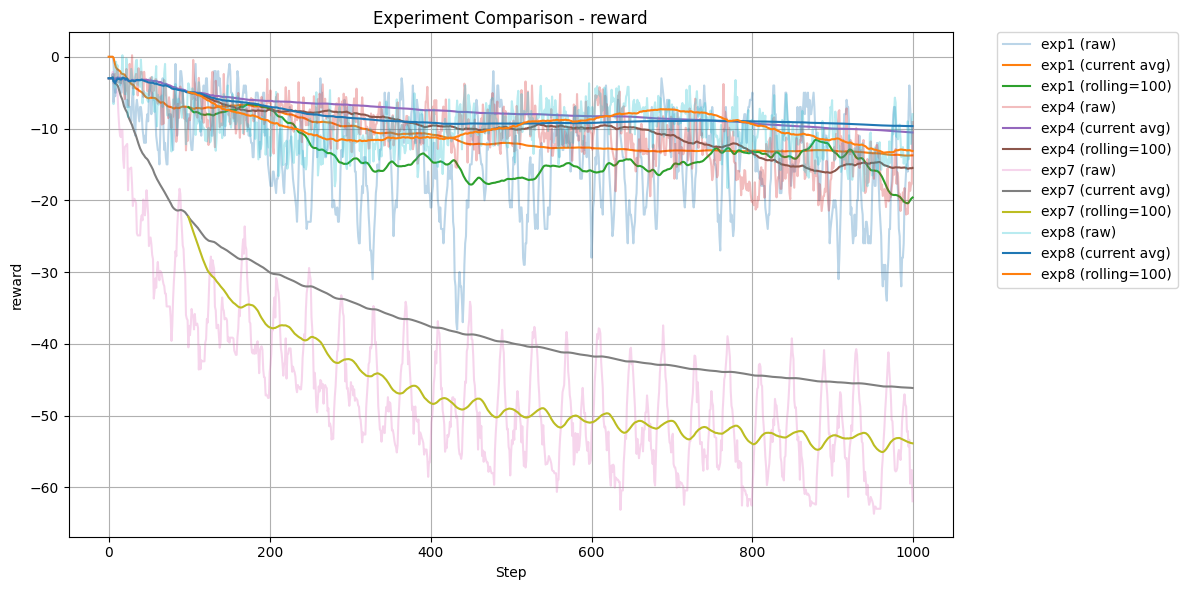

In [ ]:
plot_experiment_metrics(
    experiment_files={
        "exp1": "results/stage1_exp2_rl_queue_focused_noiseFalse_evaluation_records.csv",
        "exp4": "results/stage1_exp4_rl_default_noiseTrue_evaluation_records.csv",
        "exp7": "results/stage2_exp7_heuristic_default_noiseFalse_evaluation_records.csv",
        "exp8": "results/stage2_exp8_rl_default_noiseFalse_evaluation_records.csv",
    },
    metric="reward"，
    
)

[exp1-rl-queue_based] Overall mean queue_length: 13.7430
[exp4-rl-combined_based] Overall mean queue_length: 18.2020
[exp7-baseline] Overall mean queue_length: 79.6790
[exp8-rl-combined_based] Overall mean queue_length: 15.6370


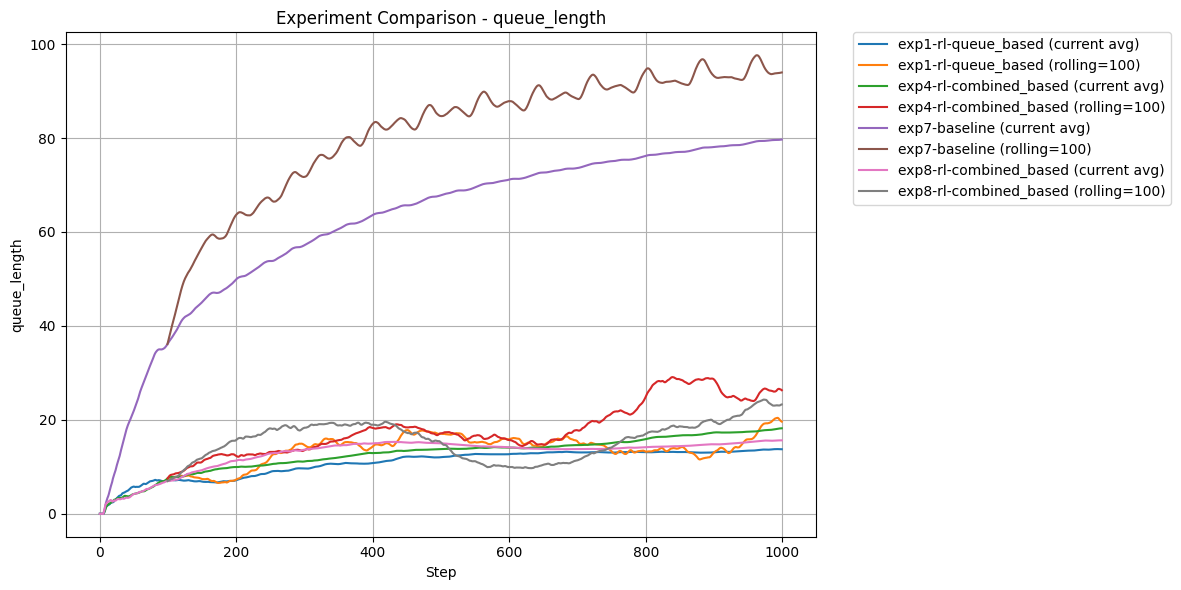

In [50]:
plot_experiment_metrics(
    experiment_files={
        "exp1-rl-queue_based": "results/stage1_exp2_rl_queue_focused_noiseFalse_evaluation_records.csv",
        "exp4-rl-combined_based": "results/stage1_exp4_rl_default_noiseTrue_evaluation_records.csv",
        "exp7-baseline": "results/stage2_exp7_heuristic_default_noiseFalse_evaluation_records.csv",
        "exp8-rl-combined_based": "results/stage2_exp8_rl_default_noiseFalse_evaluation_records.csv",
    },
    metric="queue_length",
    show_raw=False,
)

[exp1] Overall mean throughput: 0.3980
[exp4] Overall mean throughput: 0.4560
[exp7] Overall mean throughput: 0.2150
[exp8] Overall mean throughput: 0.4390


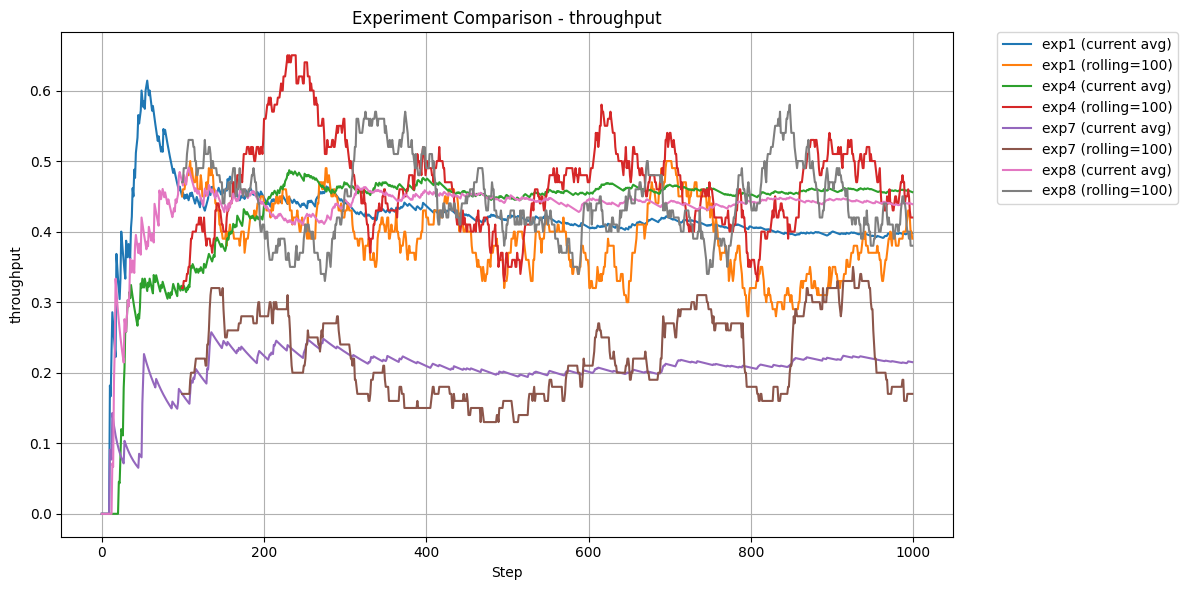

In [39]:
plot_experiment_metrics(
    experiment_files={
        "exp1": "results/stage1_exp2_rl_queue_focused_noiseFalse_evaluation_records.csv",
        "exp4": "results/stage1_exp4_rl_default_noiseTrue_evaluation_records.csv",
        "exp7": "results/stage2_exp7_heuristic_default_noiseFalse_evaluation_records.csv",
        "exp8": "results/stage2_exp8_rl_default_noiseFalse_evaluation_records.csv",
    },
    metric="throughput",
    show_raw=False
)